In [105]:
import torch
import torch.nn.functional as F

import torchsde

import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

In [32]:
class Net(torch.nn.Module):

    def __init__(self, input_dim=1):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        # an affine operation: y = Wx + b
        self.input_dim = input_dim
        self.fc1 = torch.nn.Linear(input_dim, 120)  # 5*5 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, input_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [93]:
import torch

batch_size, state_size, brownian_size = 32, 3, 2
t_size = 20

class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self, state_size=1, brownian_size=1, batch_size=10, γ=1.0):
        super().__init__()
        
        self.state_size = state_size
        self.brownian_size = brownian_size
        self.batch_size = batch_size

        self.γ = torch.tensor(γ)
        self.μ = Net(input_dim=state_size)
        self.σ = lambda x: self.γ * torch.eye(self.state_size, self.brownian_size).repeat(batch_size,1)

    # Drift
    def f(self, t, y):
        return self.μ(y)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        σ = self.σ(y)
#         print(σ.shape, y.shape, self.brownian_size)
        return self.σ(y).view(self.batch_size, 
                              self.state_size, 
                              self.brownian_size)


# sde = SDE(state_size, brownian_size, batch_size, 1)
# y0 = torch.full((batch_size, state_size), 0.1)
# ts = torch.linspace(0, 1, t_size)
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
# ys = torchsde.sdeint(sde, y0, ts)

In [97]:
def log_g(Θ, ln_prior, ln_like, γ=1.0):
    """
    g function in control objective
    
    g is the Radon-Nikodym derivtive between
    the joint and N(0, γ I)
    """
    normal_term = -0.5 * (Θ**2).sum(axis=1) / γ
    return ln_prior(Θ) + ln_like(Θ) - normal_term

def log_likelihood(Θ, X, y):
#     import pdb; pdb.set_trace()
    logits = X.mm(Θ.T)
    
    pos_weights = torch.ones(logits.shape[0]*logits.shape[1])
    loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights, reduction="sum")
    vector_loss = loss(logits.reshape(-1), y.reshape(-1,1).repeat(1, logits.shape[1]).reshape(-1))
    return vector_loss / Θ.shape[0]

def gaussian_prior(Θ, σ_w=0.9):
    return -0.5 * (Θ**2).sum(axis=1) / σ_w

def relative_entropy_control_cost(sde, Θ_0, X, y, ln_prior, ln_like, Δt=0.05, γ=1.0):
    """
    Objective for the Hamilton-Bellman-Jacobi Follmer Sampler
    """
    n = int(1.0 / Δt)
    ts = torch.linspace(0, 1, n)
    
    ln_like_partial = lambda Θ: log_likelihood(Θ, X, y)
    
    Θs =  torchsde.sdeint(sde, Θ_0, ts)
    μs = sde.f(ts, Θs)
    ΘT = Θs[:,-1,:]
    lng = log_g(ΘT, ln_prior, ln_like_partial, γ).mean()
    girsanov_factor = 0.5 * ((μs**2).sum(axis=-1)).mean()
    
    return girsanov_factor - lng

In [52]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']

# Binary classification
X = X[~(y==2)][:,[0,1]]
y = y[~(y==2)]

# dummy dims 
X = np.concatenate((torch.ones(X.shape[0],1), torch.tensor(X) ), axis=1)

names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


X_train, X_test, y_train, y_test = torch.tensor(X_train), torch.tensor(X_test), torch.tensor(y_train), torch.tensor(y_test) 

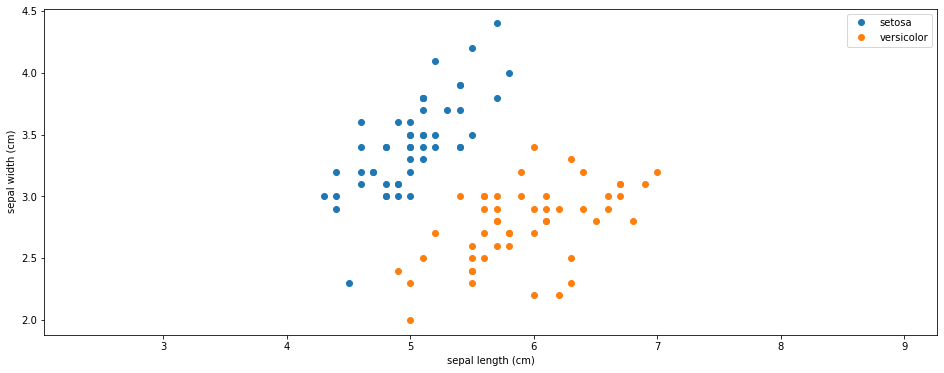

In [53]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
for target, target_name in enumerate(names[0:2]):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 1], X_plot[:, 2], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();


In [99]:
t_size = 20
dim = 3

sde = SDE(dim, dim, X.shape[0], 1)
Θ_0 = torch.full((X.shape[0], dim), 0.1) * 0
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts)

In [100]:
relative_entropy_control_cost(sde, Θ_0.float(), X_train.float(), y_train.float(), gaussian_prior, log_likelihood)

tensor(-68.5357, grad_fn=<SubBackward0>)

In [ ]:


optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.0001)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 30
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer, torch.optim.LBFGS):
        def closure():
            loss = relative_entropy_control_cost(
                sde, Θ_0.float(),
                X_train.float(), y_train.float(),
                gaussian_prior, log_likelihood
            )
            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().item())
    else:
        loss = relative_entropy_control_cost(
            sde, Θ_0.float(),
            X_train.float(), y_train.float(),
            gaussian_prior, log_likelihood
        )
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

In [109]:
losses

[-101.66273498535156,
 -139.53704833984375,
 -88.05824279785156,
 -114.9361343383789,
 -90.03571319580078,
 -117.8824691772461,
 -53.55495834350586,
 -134.0515594482422,
 -108.8211441040039,
 -131.85755920410156,
 -110.71451568603516,
 -98.80561828613281,
 -110.25175476074219,
 -60.49855041503906,
 -106.07586669921875,
 -106.73676300048828,
 -115.3475112915039,
 -163.05593872070312,
 -108.78644561767578,
 -119.6936264038086,
 -122.12637329101562,
 -165.67750549316406,
 -91.27678680419922,
 -111.3314208984375,
 -175.8997802734375,
 -119.38237762451172,
 -174.40335083007812,
 -141.95693969726562,
 -94.78857421875,
 -164.5984649658203]